#### MLAI Week 5: Generalisation

### Neil D. Lawrence

### 27th October 2015

### Review
- Last time: introduced basis functions.
- Showed how to maximize the likelihood of a non-linear model that's linear in parameters.
- Explored the different characteristics of different basis function models

### Polynomial Fits to Olymics Data

In [1]:
import pods
import numpy as np
import scipy as sp
import mlai
from matplotlib import pyplot as plt
max_basis = 7
basis = mlai.polynomial

data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

data_limits = [1892, 2020]
num_data = x.shape[0]


In [2]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

ll = np.array([np.nan]*(max_basis))
sum_squares = np.array([np.nan]*(max_basis))

for num_basis in range(1,max_basis+1):
    
    model= mlai.LM(x, y, basis, num_basis=num_basis, data_limits=data_limits)
    model.fit()
    sum_squares[num_basis-1] = model.objective()/num_data 
    ll[num_basis-1] = model.log_likelihood()
    mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                           objective=np.sqrt(sum_squares), objective_ylim=[0, 0.3],
                           title='Root Mean Square Training Error',
                           fig=f, ax=ax)


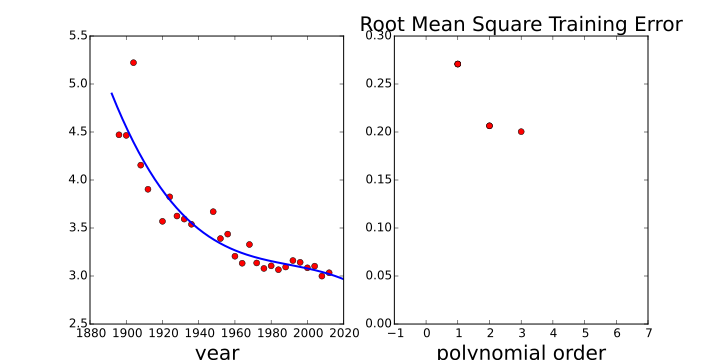

In [3]:
pods.notebook.display_plots('olympic_LM_polynomial{num_basis}.svg', 
                            directory='./diagrams', num_basis=(1, max_basis))

### Overfitting
- Increase number of basis functions we obtain a better 'fit' to the data.
- How will the model perform on previously unseen data?
- Let's consider predicting the future.

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

val_start = 20;
x = data['X'][:val_start, :]
x_val = data['X'][val_start:, :]
y = data['Y'][:val_start, :]
y_val = data['Y'][val_start:, :]
num_val_data = x_val.shape[0]
 

ll = np.array([np.nan]*(max_basis))
ss = np.array([np.nan]*(max_basis))
ss_val = np.array([np.nan]*(max_basis))
for num_basis in range(1,max_basis+1):
    
    model= mlai.LM(x, y, basis, num_basis=num_basis, data_limits=data_limits)
    model.fit()
    ss[num_basis-1] = model.objective()
    f_val, _ = model.predict(x_val)
    ss_val[num_basis-1] = ((y_val-f_val)**2).mean() 
    ll[num_basis-1] = model.log_likelihood()
    mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                           objective=np.sqrt(ss_val), objective_ylim=[0,0.6],
                           fig=f, ax=ax, prefix='olympic_val',
                           title="Hold Out Validation",
                           x_val=x_val, y_val=y_val)

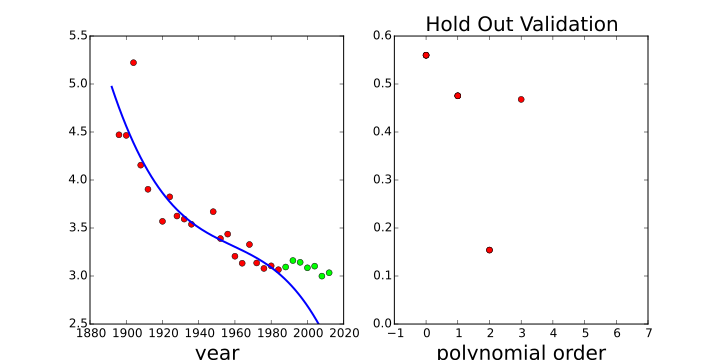

In [5]:
pods.notebook.display_plots('olympic_val_LM_polynomial{num_basis}.svg', 
                            directory='./diagrams', num_basis=(1, max_basis))

### Extrapolation

- Here we are training beyond where the model has learnt.
- This is known as *extrapolation*.
- Extrapolation is predicting into the future here, but could be:
    - Predicting back to the unseen past (pre 1892)
    - Spatial prediction (e.g. Cholera rates outside Manchester given rates inside Manchester).

### Alan Turing
- He was a formidable Marathon runner. 
- In 1946 he ran a time 2 hours 46 minutes.
- What is the probability he would have won an Olympics if one had been held in 1946?  
![Alan Turing running in 1946](http://www.turing.org.uk/turing/pi2/run.jpg)
<center>*Alan Turing, in 1946 he was only 11 minutes slower than the winner of the 1948 games. Would he have won a hypothetical games held in 1946? Source: [Alan Turing Internet Scrapbook](http://www.turing.org.uk/scrapbook/run.html).*</center>


### Interpolation
- Predicting the wining time for 1946 Olympics is *interpolation*.
- This is because we have times from 1936 and 1948.
- If we want a model for *interpolation* how can we test it?
- One trick is to sample the validation set from throughout the data set.

In [6]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

val_start = 20;

perm = np.random.permutation(data['X'].shape[0])
x = data['X'][perm[:val_start], :]
x_val = data['X'][perm[val_start:], :]
y = data['Y'][perm[:val_start], :]
y_val = data['Y'][perm[val_start:], :]
num_val_data = x_val.shape[0]
 
    


ll = np.array([np.nan]*(max_basis))
ss = np.array([np.nan]*(max_basis))
ss_val = np.array([np.nan]*(max_basis))
for num_basis in range(1,max_basis+1):
    
    model= mlai.LM(x, y, basis, num_basis=num_basis, data_limits=data_limits)
    model.fit()
    ss[num_basis-1] = model.objective()
    f_val, _ = model.predict(x_val)
    ss_val[num_basis-1] = ((y_val-f_val)**2).mean() 
    ll[num_basis-1] = model.log_likelihood()
    mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                           objective=np.sqrt(ss_val), objective_ylim=[0.1,0.6],
                           fig=f, ax=ax, prefix='olympic_val_inter',
                           title="Hold Out Validation",
                           x_val=x_val, y_val=y_val)

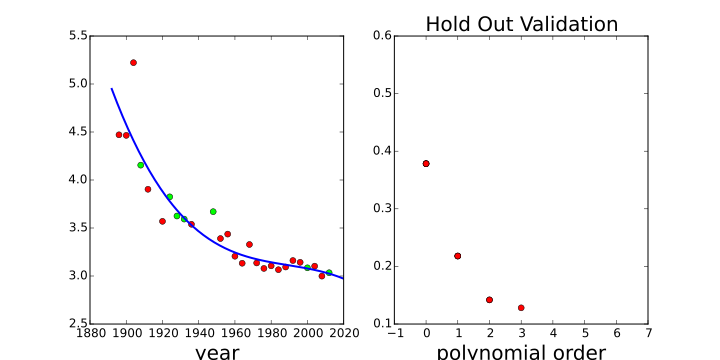

In [7]:
pods.notebook.display_plots('olympic_val_inter_LM_polynomial{num_basis}.svg', 
                            directory='./diagrams', num_basis=(1, max_basis))

### Choice of Validation Set

- The choice of validation set should reflect how you will use the model in practice.
- For extrapolation into the future we tried validating with data from the future.
- For interpolation we chose validation set from data.
- For different validation sets we could get different results.

### Leave One Out Error
- Take training set and remove one point.
- Train on the remaining data.
- Compute the error on the point you removed (which wasn't in the training data).
- Do this for each point in the training set in turn.
- Average the resulting error. 
- This is the leave one out error.

In [14]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

num_data = data['X'].shape[0]
num_parts = num_data
partitions = []
for part in range(num_parts):
    train_ind = list(range(part))
    train_ind.extend(range(part+1,num_data))
    val_ind = [part]
    partitions.append((train_ind, val_ind))

    ll = np.array([np.nan]*(max_basis))
    ss = np.array([np.nan]*(max_basis))
    ss_val = np.array([np.nan]*(max_basis))
    for num_basis in range(1,max_basis+1):
        ss_val_temp = 0.
        for part, (train_ind, val_ind) in enumerate(partitions):
            x = data['X'][train_ind, :]
            x_val = data['X'][val_ind, :]
            y = data['Y'][train_ind, :]
            y_val = data['Y'][val_ind, :]
            num_val_data = x_val.shape[0]

            model= mlai.LM(x, y, basis, num_basis=num_basis, data_limits=data_limits)
            model.fit()
            ss[num_basis-1] = model.objective()
            f_val, _ = model.predict(x_val)
            ss_val_temp += ((y_val-f_val)**2).mean() 
            mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                                objective=np.sqrt(ss_val), objective_ylim=[0.1,0.6],
                                   fig=f, ax=ax, prefix='olympic_loo' + str(part) + '_inter',
                                   x_val=x_val, y_val=y_val)
        ss_val[num_basis-1] = ss_val_temp/(num_parts)
        ax[1].cla()
        mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                                objective=np.sqrt(ss_val), objective_ylim=[0.1,0.6],
                                   fig=f, ax=ax, prefix='olympic_loo' + str(len(partitions)) + '_inter',
                                   title="Leave One Out Validation",
                                   x_val=x_val, y_val=y_val)
        

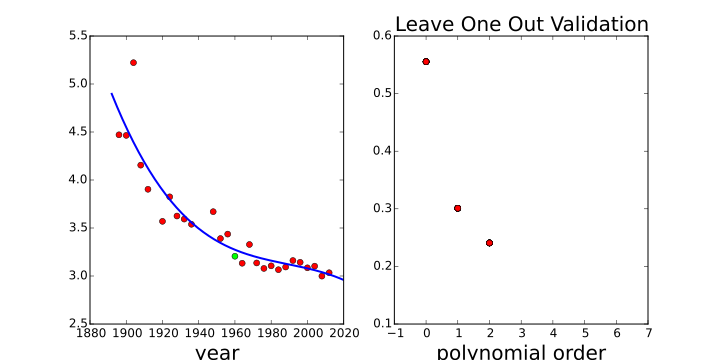

In [15]:
pods.notebook.display_plots('olympic_loo{part}_inter_LM_polynomial{num_basis}.svg', 
                            directory='./diagrams', num_basis=(1, max_basis), part=(0,len(partitions)))

### Bias Variance Decomposition

Expected test error for different variations of the *training data* sampled from, $\Pr(\mathbf{x}, y)$

$$\mathbb{E}\left[ (y - f^*(\mathbf{x}))^2 \right]$$

Decompose as

$$\mathbb{E}\left[ (y - f(\mathbf{x}))^2 \right] = \text{bias}\left[f^*(\mathbf{x})\right]^2 + \text{variance}\left[f^*(\mathbf{x})\right] +\sigma^2$$


### Bias

- Given by
    $$\text{bias}\left[f^*(\mathbf{x})\right] = \mathbb{E}\left[f^*(\mathbf{x})\right] - f(\mathbf{x})$$
    
- Error due to bias comes from a model that's too simple.

### Variance

- Given by
    $$\text{variance}\left[f^*(\mathbf{x})\right] = \mathbb{E}\left[\left(f^*(\mathbf{x}) -  \mathbb{E}\left[f^*(\mathbf{x})\right]\right)^2\right]$$
    
- Slight variations in the training set cause changes in the prediction. Error due to variance is error in the model due to an overly complex model. 

### $k$ Fold Cross Validation

- Leave one out error can be very time consuming.
- Need to train your algorithm $n$ times.
- An alternative: $k$ fold cross validation.

In [10]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

num_data = data['X'].shape[0]
num_parts = 5
partitions = []
ind = list(np.random.permutation(num_data))
start = 0
for part in range(num_parts):
    end = round((float(num_data)/num_parts)*(part+1))
    train_ind = ind[:start]
    train_ind.extend(ind[end:])
    val_ind = ind[start:end]
    partitions.append((train_ind, val_ind))
    start = end

    
max_basis = 7

ll = np.array([np.nan]*(max_basis))
ss = np.array([np.nan]*(max_basis))
ss_val = np.array([np.nan]*(max_basis))
for num_basis in range(1,max_basis+1):
    ss_val_temp = 0.
    for part, (train_ind, val_ind) in enumerate(partitions):
        x = data['X'][train_ind, :]
        x_val = data['X'][val_ind, :]
        y = data['Y'][train_ind, :]
        y_val = data['Y'][val_ind, :]
        num_val_data = x_val.shape[0]

        model= mlai.LM(x, y, basis, num_basis=num_basis, data_limits=data_limits)
        model.fit()
        ss[num_basis-1] = model.objective()
        f_val, _ = model.predict(x_val)
        ss_val_temp += ((y_val-f_val)**2).mean() 
        mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                            objective=np.sqrt(ss_val), objective_ylim=[0.2,0.6],
                               fig=f, ax=ax, prefix='olympic_' + str(num_parts) + 'cv' + str(part) + '_inter',
                               title='5-fold Cross Validation',
                               x_val=x_val, y_val=y_val)
    ss_val[num_basis-1] = ss_val_temp/(num_parts)
    ax[1].cla()
    mlai.plot_marathon_fit(model=model, data_limits=data_limits, 
                            objective=np.sqrt(ss_val), objective_ylim=[0.2,0.6],
                            fig=f, ax=ax, prefix='olympic_' + str(num_parts) + 'cv' + str(len(partitions)) + '_inter',
                            title='5-fold Cross Validation',
                            x_val=x_val, y_val=y_val)

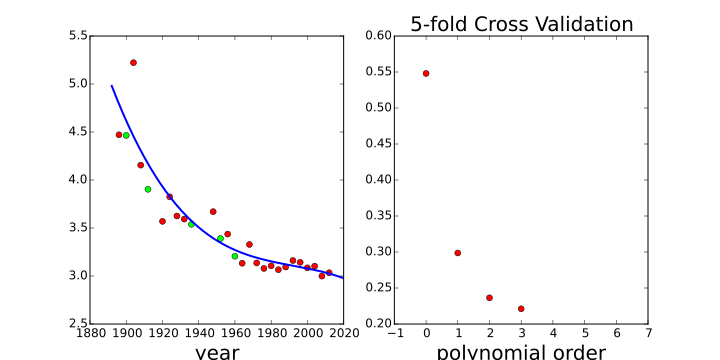

In [11]:
pods.notebook.display_plots('olympic_5cv{part}_inter_LM_polynomial{num_basis}.svg', 
                            directory='./diagrams', num_basis=(1, max_basis), part=(0,5))

### Reading
- Section 1.5 of @Rogers:book11